In [2]:
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
%matplotlib inline
plt.style.use('seaborn-dark')
import matplotlib.gridspec as gridspec
from multiprocessing import Pool
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from datetime import datetime
dateTime = lambda self: self.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")

In [3]:
%run def_plots.ipynb

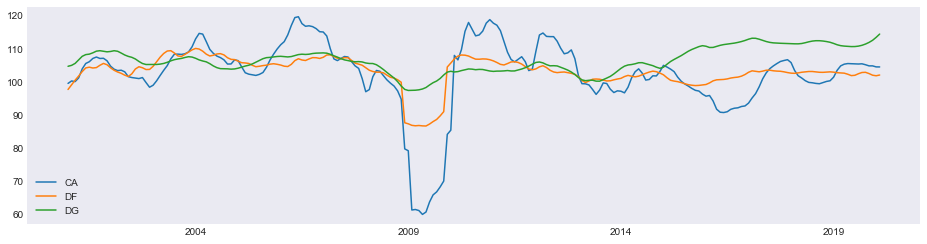

In [4]:
df_init=pd.read_excel('data/demetra_ipp_1_2020.xlsx',sheet_name='t_ch',skiprows=1)
df_init=df_init[['CA','DF','DG']].dropna()
my_dates=pd.date_range(start='2001-01-31',periods=len(df_init),freq='M')
df_init.index=my_dates
df_init.plot(figsize=(16,4))

In [5]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [6]:
scl = StandardScaler()
df_init_scal = scl.fit_transform(df_init.values)#сохраняем мат и дисп для скал тестовой выборки

In [7]:
# df_init_scal

In [8]:
def prep_data(ncol):
    a=df_init_scal[:,ncol].reshape(230,1)
    b=np.roll(df_init_scal[:,ncol],-1).reshape(230,1)
    return np.hstack([a,b])

In [9]:
data_sep=200
print('точка разделения данных: {}'.format(my_dates[data_sep]))
n_steps=6
X_cnn,y_cnn=split_sequences(prep_data(0), n_steps)
print('размерность не разбитой выборки:',X_cnn.shape, y_cnn.shape)
print()
print('размерность преобразованных тренировочных данных для снн с окном', n_steps,'равна',X_cnn[:data_sep-n_steps+2].shape, y_cnn[:data_sep-n_steps+2].shape)
X_cnn_train1=X_cnn[:data_sep-n_steps+2]
X_cnn_test1=X_cnn[data_sep-n_steps+1:]
print('размерность тестовых данных равна',X_cnn_test1.shape)
y_cnn_train1=y_cnn[:data_sep-n_steps+2]
y_cnn_test1=y_cnn[data_sep-n_steps+1:]

точка разделения данных: 2017-09-30 00:00:00
размерность не разбитой выборки: (225, 6, 1) (225,)

размерность преобразованных тренировочных данных для снн с окном 6 равна (196, 6, 1) (196,)
размерность тестовых данных равна (30, 6, 1)


In [10]:
def prep_data_2(stacked,n_steps=n_steps,data_sep=data_sep):
        X,y=split_sequences(stacked, n_steps)
        X_train=X[:data_sep-n_steps+2]
        X_test=X[data_sep-n_steps+1:]
        y_train=y[:data_sep-n_steps+2]
        y_test=y[data_sep-n_steps+1:]
        return X_train,X_test,y_train,y_test

In [11]:
X_train1,X_test1,y_train1,y_test1=prep_data_2(prep_data(0))
X_train2,X_test2,y_train2,y_test2=prep_data_2(prep_data(1))
X_train3,X_test3,y_train3,y_test3=prep_data_2(prep_data(2))


In [12]:
x = np.arange(20).reshape(2, 10)
x.shape

(2, 10)

In [13]:
y = np.arange(20).reshape(2, 10)

In [14]:
from keras.models import Sequential, Model 
from matplotlib import pyplot
from keras.layers import LeakyReLU

from keras.models import Model 
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers import LSTM, GRU
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
import keras.backend as K

import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

def size(model): # Compute number of params in a model (the actual number of floats)
    return sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])

Using TensorFlow backend.


### LSTM 

In [65]:
def get_hist_ulstm(xtrain):#,ytrain,xtest,ytest):
    n_features1= xtrain.shape[2]
    ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
    lstm1=LSTM(6, activation='relu', input_shape=(n_steps, n_features1))(ipp_1)

    ipp_1_pred=Dense(1,activation='linear', name='out_1')(lstm1)
    model = Model([ipp_1],[ipp_1_pred])
    model.compile(optimizer='adam',
                  loss={'out_1': 'mse'},
                metrics=['mse', 'mae', 'mape'])
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fact_ipp_1 (InputLayer)      (None, 6, 1)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 6)                 192       
_________________________________________________________________
out_1 (Dense)                (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


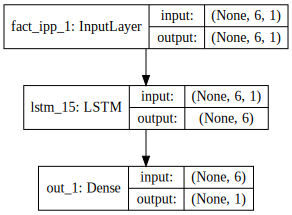

In [66]:
my_model=get_hist_ulstm(X_train1)
my_model.summary()
plot_model(my_model, to_file='plots/models/model'+dateTime(datetime)+'.png',show_shapes=True)
SVG(model_to_dot(my_model,show_shapes=True).create(prog='dot', format='svg'))

In [67]:
print ('Отношение числа наблюдений к кол-ву оцениваемых параметров в одной ветке: {}'\
       .format(round((X_cnn_train1.shape[0]*X_cnn_train1.shape[1])/size(my_model),2)))

Отношение числа наблюдений к кол-ву оцениваемых параметров в одной ветке: 5.91


In [80]:
%%time
model1=get_hist_ulstm(X_train1)
model2=get_hist_ulstm(X_train2)
model3=get_hist_ulstm(X_train3)

histor1=model.fit({'fact_ipp_1': X_train1},{'out_1':y_train1},validation_data=({'fact_ipp_1': X_test1},
          {'out_1':y_test1}),epochs=200, batch_size=len(X_test1),verbose=0)
histor2=model.fit({'fact_ipp_1': X_train2},{'out_1':y_train2},validation_data=({'fact_ipp_1': X_test2},
          {'out_1':y_test2}),epochs=200, batch_size=len(X_test2),verbose=0)
histor3=model.fit({'fact_ipp_1': X_train3},{'out_1':y_train3},validation_data=({'fact_ipp_1': X_test3},
          {'out_1':y_test3}),epochs=200, batch_size=len(X_test1),verbose=0)
                         

CPU times: user 37.6 s, sys: 11.9 s, total: 49.5 s
Wall time: 23.6 s


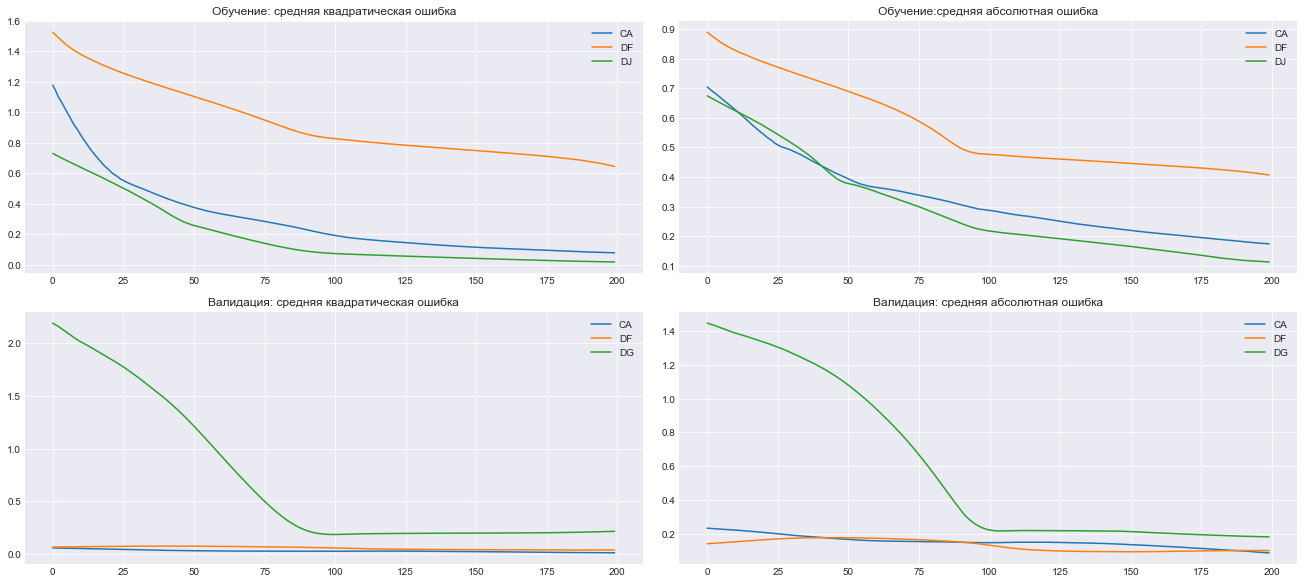

In [81]:
plot_metrics_uniq(history1,history2,history3,save=True,comment='p')

In [92]:
#для чистоты эксперемента тут нужно и test выборку пересобирать с учетом предсказаний
def with_rolling(model, X_train1, y_train1, X_test1, y_test1):
    y_hat=np.array([])
    for i in range(0,len(y_test1)):
        history=model.fit(X_train1,y_train1, epochs=200, batch_size=len(X_train1),verbose=0)
        y_hat=np.hstack([y_hat,model.predict(X_test1[i].reshape(1,6,1))[0]])
        X_train1=np.concatenate((X_train1,X_test1[i].reshape(1,6,1)))
        y_train1=np.append(y_train1,y_test1[i])
    return y_hat

In [93]:
%%time
pred1=with_rolling(model1,X_train1, y_train1, X_test1, y_test1)
pred2=with_rolling(model2,X_train2, y_train2, X_test2, y_test2)
pred3=with_rolling(model3,X_train3, y_train3, X_test3, y_test3)


CPU times: user 2min 47s, sys: 47.3 s, total: 3min 34s
Wall time: 1min 38s


In [94]:
pred_ulstm,init_test,forectest_mse=make_forectest_df(pred1.reshape((30,1)),
                                                     pred2.reshape((30,1)),
                                                     pred3.reshape((30,1)))

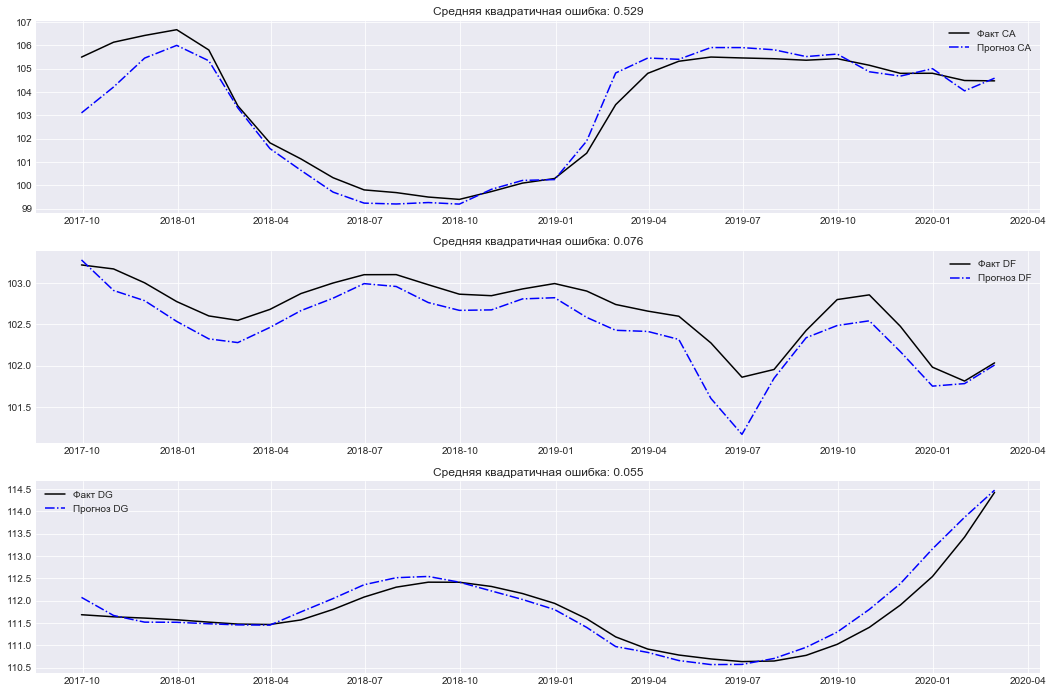

In [96]:
plot_forec_val(pred_ulstm,init_test,forectest_mse,save=True)

In [83]:
class my_LSTM():

    def __init__(self, model, train, test):

        self.train=train
        self.test=test 
        assert(test!=0)#проверка условия
        
    def unique():
        print('hi1')
    
    def stack():
        print('hi2')
        my_LSTM.unique()

In [84]:
my_LSTM.stack()

hi2
hi1


### LSTM stack

In [90]:
# def my_stack_lstm()
n_features1,n_features2,n_features3= X_train1.shape[2],X_train2.shape[2],X_train3.shape[2]


ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
ipp_2 = Input(shape=(n_steps, n_features2),name='fact_ipp_2')
ipp_3 = Input(shape=(n_steps, n_features3),name='fact_ipp_3')


lstm1=LSTM(3, activation='relu', input_shape=(n_steps, n_features1))(ipp_1)
lstm2=LSTM(3, activation='relu', input_shape=(n_steps, n_features2))(ipp_2)
lstm3=LSTM(3, activation='relu', input_shape=(n_steps, n_features3))(ipp_3)


merge = concatenate([lstm1, lstm2, lstm3],axis=-1)

# merge=Reshape((5,3))(merge)
# merge = Flatten()(merge)

ipp_1_pred=Dense(1,activation='linear', name='out_1')(merge)
ipp_2_pred=Dense(1,activation='linear', name='out_2')(merge)
ipp_3_pred=Dense(1,activation='linear', name='out_3')(merge)

model = Model([ipp_1, ipp_2,ipp_3],[ipp_1_pred,ipp_2_pred,ipp_3_pred])


model.compile(optimizer='adam',
              loss={'out_1': 'mse','out_2': 'mse',
                    'out_3': 'mse'},
              
              loss_weights={'out_1': 1,
                            'out_2': 1,
                            'out_3': 1},
            metrics=['mse', 'mae', 'mape'])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fact_ipp_1 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
fact_ipp_2 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
fact_ipp_3 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 3)            60          fact_ipp_1[0][0]                 
__________________________________________________________________________________________________
lstm_11 (L

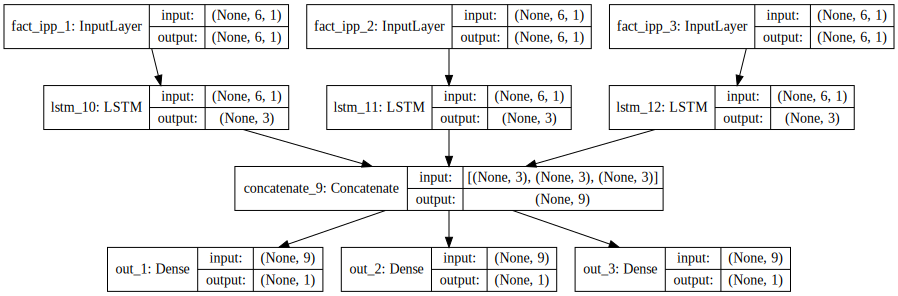

In [91]:
model.summary()
plot_model(model, to_file='plots/models/model'+dateTime(datetime)+'.png',show_shapes=True)
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


### GRU unique

In [92]:
# def simple_gru(IPP)
n_features1= X_train1.shape[2]


ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
gru1=GRU(3, activation='relu', input_shape=(n_steps, n_features1))(ipp_1)
ipp_1_pred=Dense(1,activation='linear', name='out_1')(gru1)

model = Model([ipp_1],[ipp_1_pred])

model.compile(optimizer='adam',
              loss={'out_1': 'mse'},

            metrics=['mse', 'mae', 'mape'])

history=model.fit({'fact_ipp_1': X_train1},
          {'out_1':y_train1},
                  validation_data=({'fact_ipp_1': X_test1},
          {'out_1':y_test1}),
          epochs=200, batch_size=100,verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fact_ipp_1 (InputLayer)      (None, 6, 1)              0         
_________________________________________________________________
gru_6 (GRU)                  (None, 3)                 45        
_________________________________________________________________
out_1 (Dense)                (None, 1)                 4         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


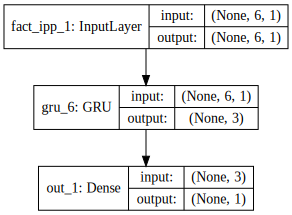

In [93]:
model.summary()
plot_model(model, to_file='plots/models/model'+dateTime(datetime)+'.png',show_shapes=True)
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


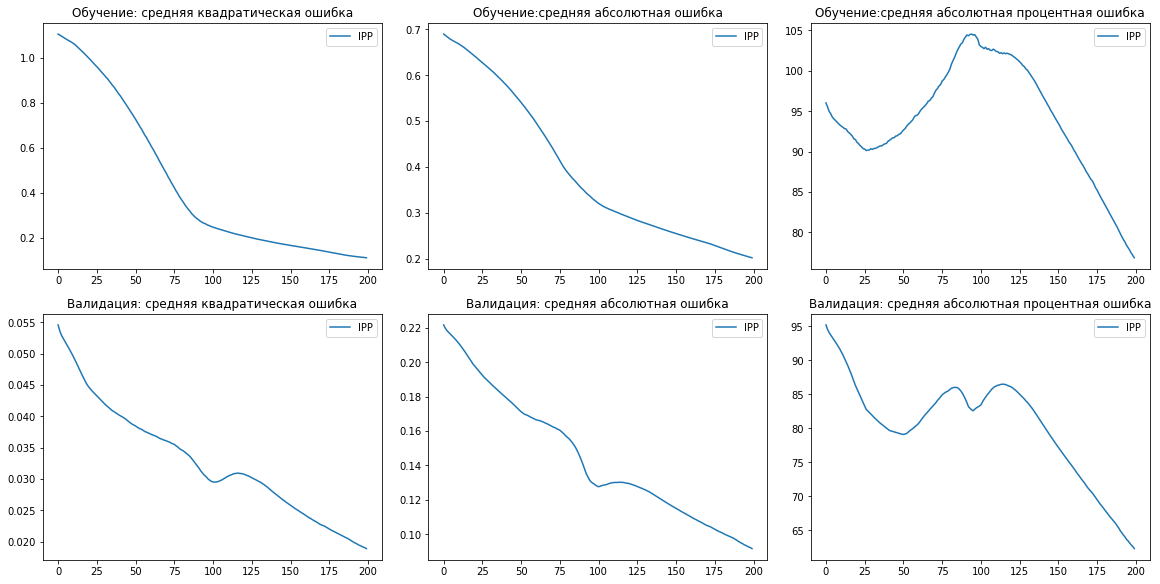

In [31]:
plot_metrics_unique(history,save=False,comment='a',mylable='IPP')

### GRU stack

In [94]:
# def my_stack_gru()
n_features1,n_features2,n_features3= X_train1.shape[2],X_train2.shape[2],X_train3.shape[2]


ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
ipp_2 = Input(shape=(n_steps, n_features2),name='fact_ipp_2')
ipp_3 = Input(shape=(n_steps, n_features3),name='fact_ipp_3')


gru1=GRU(3, activation='relu', input_shape=(n_steps, n_features1))(ipp_1)
gru2=GRU(3, activation='relu', input_shape=(n_steps, n_features2))(ipp_2)
gru3=GRU(3, activation='relu', input_shape=(n_steps, n_features3))(ipp_3)


merge = concatenate([gru1, gru2, gru3],axis=-1)

# merge=Reshape((5,3))(merge)
# merge = Flatten()(merge)

ipp_1_pred=Dense(1,activation='linear', name='out_1')(merge)
ipp_2_pred=Dense(1,activation='linear', name='out_2')(merge)
ipp_3_pred=Dense(1,activation='linear', name='out_3')(merge)

model = Model([ipp_1, ipp_2,ipp_3],[ipp_1_pred,ipp_2_pred,ipp_3_pred])


model.compile(optimizer='adam',
              loss={'out_1': 'mse','out_2': 'mse',
                    'out_3': 'mse'},
              
              loss_weights={'out_1': 1,
                            'out_2': 1,
                            'out_3': 1},
            metrics=['mse', 'mae', 'mape'])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fact_ipp_1 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
fact_ipp_2 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
fact_ipp_3 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
gru_7 (GRU)                     (None, 3)            45          fact_ipp_1[0][0]                 
__________________________________________________________________________________________________
gru_8 (GRU

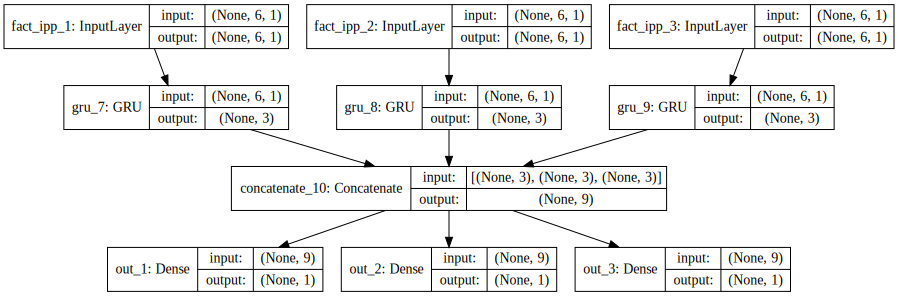

In [95]:
model.summary()
plot_model(model, to_file='plots/models/model'+dateTime(datetime)+'.png',show_shapes=True)
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


### CNN unique

In [102]:
# def simple_gru(IPP)
n_features1= X_train1.shape[2]


ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
cnn1 = Conv1D(filters=4, kernel_size=4, activation='relu',activity_regularizer=regularizers.l2(0.01))(ipp_1)

merge = Conv1D(filters=1, kernel_size=1, activation='relu',activity_regularizer=regularizers.l2(0.01))(cnn1)
merge = Flatten()(merge)

ipp_1_pred=Dense(1,activation='linear', name='out_1')(merge)


model = Model([ipp_1],[ipp_1_pred])

model.compile(optimizer='adam',
              loss={'out_1': 'mse'},

            metrics=['mse', 'mae', 'mape'])

history=model.fit({'fact_ipp_1': X_train1},
          {'out_1':y_train1},
                  validation_data=({'fact_ipp_1': X_test1},
          {'out_1':y_test1}),
          epochs=200, batch_size=100,verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fact_ipp_1 (InputLayer)      (None, 6, 1)              0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 3, 4)              20        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 3, 1)              5         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3)                 0         
_________________________________________________________________
out_1 (Dense)                (None, 1)                 4         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


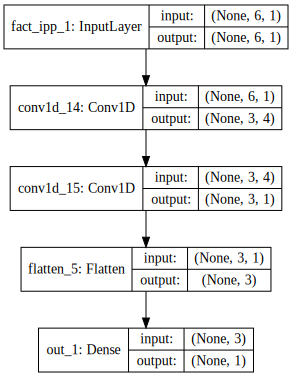

In [103]:
model.summary()
plot_model(model, to_file='plots/models/model'+dateTime(datetime)+'.png',show_shapes=True)
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


### CNN stack

In [22]:
# def my_stack_cnn()
n_features1,n_features2,n_features3= X_train1.shape[2],X_train2.shape[2],X_train3.shape[2]


ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
ipp_2 = Input(shape=(n_steps, n_features2),name='fact_ipp_2')
ipp_3 = Input(shape=(n_steps, n_features3),name='fact_ipp_3')

cnn1 = Conv1D(filters=2, kernel_size=4, activation='relu',activity_regularizer=regularizers.l2(0.01))(ipp_1)
cnn2 = Conv1D(filters=2, kernel_size=4, activation='relu',activity_regularizer=regularizers.l2(0.01))(ipp_2)
cnn3 = Conv1D(filters=2, kernel_size=4, activation='relu',activity_regularizer=regularizers.l2(0.01))(ipp_3)

merge = concatenate([cnn1, cnn2, cnn3],axis=-1)#что дает -1? не переворачивает ли она вверх ногами матрицу?
merge = Conv1D(filters=1, kernel_size=1, activation='relu',activity_regularizer=regularizers.l2(0.01))(merge)
merge = Flatten()(merge)

ipp_1_pred=Dense(1,activation='linear', name='out_1')(merge)
ipp_2_pred=Dense(1,activation='linear', name='out_2')(merge)
ipp_3_pred=Dense(1,activation='linear', name='out_3')(merge)

model = Model([ipp_1, ipp_2,ipp_3],[ipp_1_pred,ipp_2_pred,ipp_3_pred])


model.compile(optimizer='adam',
              loss={'out_1': 'mse','out_2': 'mse',
                    'out_3': 'mse'},
              
              loss_weights={'out_1': 1,
                            'out_2': 1,
                            'out_3': 1},
            metrics=['mse', 'mae', 'mape'])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fact_ipp_1 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
fact_ipp_2 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
fact_ipp_3 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 3, 2)         10          fact_ipp_1[0][0]                 
__________________________________________________________________________________________________
conv1d_6 (

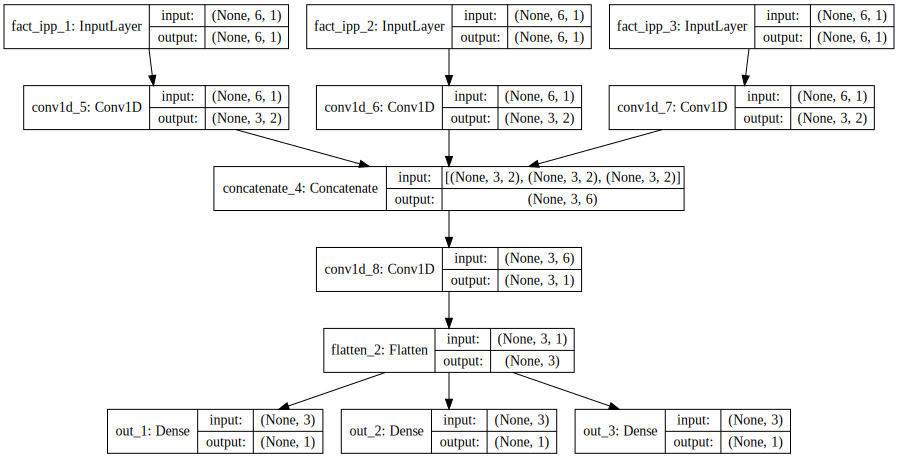

In [28]:
model.summary()
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
print ('Отношение числа наблюдений к кол-ву оцениваемых параметров в одной ветке: {}'\
       .format(round((X_cnn_train1.shape[0]*X_cnn_train1.shape[1])/size(model),2)))

history=model.fit({'fact_ipp_1': X_train1, 'fact_ipp_2': X_train2,'fact_ipp_3': X_train3},
          {'out_1':y_train1,'out_2':y_train2,'out_3':y_train3},
                  validation_data=({'fact_ipp_1': X_test1, 'fact_ipp_2': X_test2,'fact_ipp_3': X_test3},
          {'out_1':y_test1,'out_2':y_test2,'out_3':y_test3}),
          epochs=200, batch_size=100,verbose=0)



plot_metrics(history,save=False,comment='a')

In [ ]:
predict=np.hstack(model.predict([X_test1,X_test2,X_test3]))
pred_inv=scl.inverse_transform(predict)#восстановить прогнозное значение ряда, только нужно для последнего ряда
init_test=df_init[my_dates[data_sep]:]

In [ ]:
pred_df=pd.DataFrame(pred_inv,index=init_test.index,columns=init_test.columns)

In [ ]:
fig2 = plt.figure(figsize=(18, 9))
spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, 0])
ax1.plot(init_test.CA, color='black', label = 'Факт CA')
ax1.plot(pred_df.CA,'-.', color='blue', label = 'Прогноз CA')
ax1.legend(loc='best')
ax2 = fig2.add_subplot(spec2[1, 0])
ax2.plot(init_test.DF, color='black', label = 'Факт DF')
ax2.plot(pred_df.DF,'-.', color='blue', label = 'Прогноз DF')
ax2.legend(loc='best')
ax3 = fig2.add_subplot(spec2[2, 0])
ax3.plot(init_test.DG, color='black', label = 'Факт DG')
ax3.plot(pred_df.DG,'-.', color='blue', label = 'Прогноз DG')
ax3.legend(loc='best')

In [24]:
pred1,pred2,pred3=model.predict([X_test1,X_test2,X_test3])
fig2 = plt.figure(figsize=(18, 9))
spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, 0])
ax1.plot(y_test1, color='black', label = 'Факт CA')
ax1.plot(pred1,'-.', color='blue', label = 'Прогноз CA')
ax1.legend(loc='best')
ax2 = fig2.add_subplot(spec2[1, 0])
ax2.plot(y_test2, color='black', label = 'Факт DF')
ax2.plot(pred2,'-.', color='blue', label = 'Прогноз DF')
ax2.legend(loc='best')
ax3 = fig2.add_subplot(spec2[2, 0])
ax3.plot(y_test3, color='black', label = 'Факт DG')
ax3.plot(pred3,'-.', color='blue', label = 'Прогноз DG')
ax3.legend(loc='best')

Отношение числа наблюдений к кол-ву оцениваемых параметров в одной ветке: 24.0


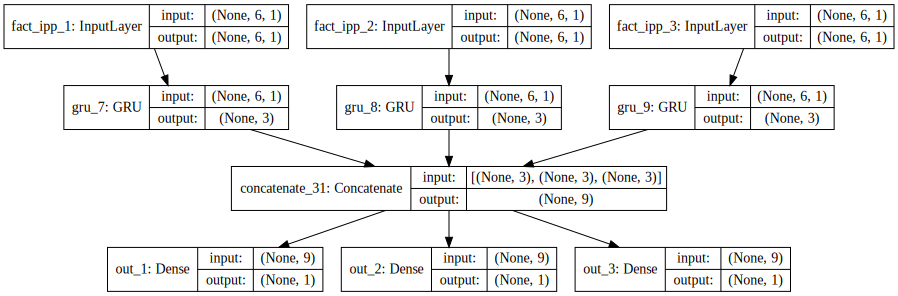

In [150]:

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [151]:

plot_model(model, to_file='model.png',show_shapes=True)